In [20]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [21]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [22]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [23]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [24]:
# reflect an existing database into a new model
base=automap_base()
# reflect the tables
base.prepare(engine,reflect=True)

In [25]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [26]:
inspector=inspect(engine)
inspector.get_columns('station')

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'name',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'latitude',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'longitude',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'elevation',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

In [27]:
inspector.get_columns('measurement')

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

In [28]:
# Save references to each table
Station=base.classes.station
Measurement=base.classes.measurement

In [29]:
# Create our session (link) from Python to the DB
session=Session(bind=engine)

# Exploratory Precipitation Analysis

In [84]:
# Find the most recent date in the data set.
recent_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"recentdate:{recent_date[0]}")

recentdate:2017-08-23


Text(0, 0.5, 'inches')

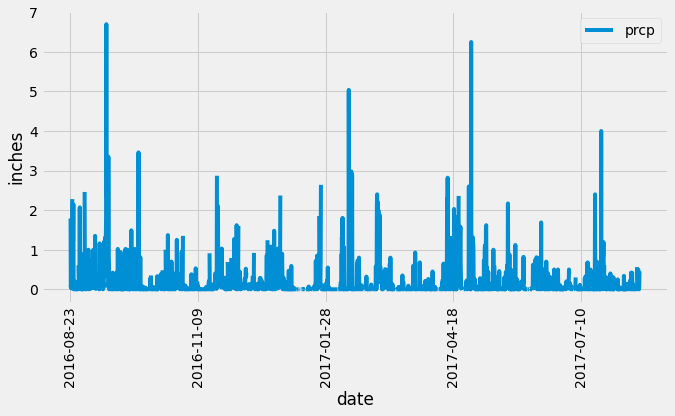

In [104]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

last_date=dt.datetime.strptime(recent_date[0],'%Y-%m-%d').date()
query_date=last_date - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores

result=session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>=query_date).all() 

# Save the query results as a Pandas DataFrame and set the index to the date column

df=pd.DataFrame(result).set_index('date')

# Sort the dataframe by date

df.sort_index(inplace=True)

df.plot(x_compat=True,rot=90,figsize=(10,5))
plt.ylabel("inches")



In [57]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [58]:
# Design a query to calculate the total number stations in the dataset
no_of_stations=session.query(func.count(Station.station)).scalar()
no_of_stations

9

In [59]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

result=session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).\
              order_by(func.count(Measurement.station).desc()).first()

print(f"most_active_station:{result[0]}")

most_active_station:USC00519281


In [64]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

sel=[Measurement.station,
    func.min(Measurement.tobs),
     func.max(Measurement.tobs),
     func.avg(Measurement.tobs)]

results=session.query(*sel).group_by(Measurement.station).filter(Measurement.station=='USC00519281').first()

print(f"Station:{results[0]},min_temp:{results[1]},max_temp:{results[2]},average_temp:{results[3]}")

Station:USC00519281,min_temp:54.0,max_temp:85.0,average_temp:71.66378066378067


In [65]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

from sqlalchemy import and_

sel=[Measurement.date,Measurement.tobs]

results=session.query(*sel).\
 filter(and_((Measurement.date>=query_date),(Measurement.station=='USC00519281'))).all() 

df=pd.DataFrame(results,columns=['date','tobs'])
df.head()

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


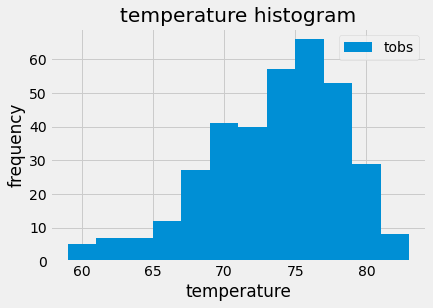

In [66]:
plot=df.plot(kind='hist',bins=12)
plt.title('temperature histogram')
plt.xlabel("temperature")
plt.ylabel('frequency')
plt.show()

In [67]:
# Close Session
session.close()